In [ ]:
!pip install transformers
!pip install datasets
!pip install evaluate
!pip install pyJoules
!pip install codecarbon
!pip install zeus-ml

In [ ]:
import torch
from transformers import DistilBertModel, DistilBertTokenizer, Trainer, TrainingArguments
from zeus.monitor import ZeusMonitor
import numpy as np
from functools import partial


In [ ]:
class SimpleEnergyMonitor:
    def __init__(self, model):
        self.model = model
        # Enable approximate instant energy calculation
        self.zeus_monitor = ZeusMonitor(approx_instant_energy=True, gpu_indices=[torch.cuda.current_device()])

        self.component_energy = {
            'attention': [],
            'ffn': [],
            'embeddings': []
        }

        # Register hooks for component-level energy tracking
        self.model.embeddings.register_forward_hook(
            partial(self._energy_hook, 'embeddings')
        )

        for layer in self.model.transformer.layer:
            layer.attention.register_forward_hook(
                partial(self._energy_hook, 'attention')
            )
            layer.ffn.register_forward_hook(
                partial(self._energy_hook, 'ffn')
            )

    def _energy_hook(self, component_name, module, input, output):
        torch.cuda.synchronize()  # Ensure GPU operations complete before measuring
        # Start and end an energy measurement window for the component
        self.zeus_monitor.begin_window(component_name)
        energy = self.zeus_monitor.end_window(component_name).total_energy
        self.component_energy[component_name].append(energy)

    def measure(self, input_ids):
        # Reset energy measurements
        for component in self.component_energy:
            self.component_energy[component].clear()

        # Start a global monitoring window for inference
        self.zeus_monitor.begin_window('inference')

        # Run inference
        with torch.no_grad():
            output = self.model(input_ids)

        # End the global monitoring window and get total energy consumption
        total_energy = self.zeus_monitor.end_window('inference').total_energy

        # Calculate energy metrics
        num_tokens = input_ids.shape[1]
        results = {
            'total_energy': total_energy,
            'energy_per_token': total_energy / num_tokens,
            'energy_per_inference': total_energy,
            'components': {
                'attention': np.sum(self.component_energy['attention']),
                'ffn': np.sum(self.component_energy['ffn']),
                'embeddings': np.sum(self.component_energy['embeddings'])
            }
        }

        return results

# Example usage
if __name__ == "__main__":
    # Setup model
    model = DistilBertModel.from_pretrained("distilbert-base-uncased").to('cuda')
    model.eval()

    # Create dummy input
    dummy_input = torch.randint(0, 30522, (1, 10), dtype=torch.long).to('cuda')

    # Measure energy
    monitor = SimpleEnergyMonitor(model)
    results = monitor.measure(dummy_input)

    # Print results
    print(f"\nEnergy Metrics (Joules):")
    print(f"Total Energy: {results['total_energy']:.4f}")
    print(f"Energy per Token: {results['energy_per_token']:.4f}")
    print(f"Energy per Inference: {results['energy_per_inference']:.4f}")
    print("\nComponent Breakdown:")
    for component, energy in results['components'].items():
        print(f"{component.title()}: {energy:.4f}")


[2024-11-17 06:35:31,923] [zeus.monitor.energy](energy.py:208) Monitoring GPU indices [0].
[2024-11-17 06:35:31,924] [zeus.monitor.energy](energy.py:209) Monitoring CPU indices []

Energy Metrics (Joules):
Total Energy: 4.7960
Energy per Token: 0.4796
Energy per Inference: 4.7960

Component Breakdown:
Attention: 0.7134
Ffn: 0.5708
Embeddings: 0.1176


In [ ]:
!pip uninstall -y pynvml nvidia-ml-py3 nvidia-ml-py
!pip cache purge
!pip install nvidia-ml-py

Found existing installation: pynvml 11.5.3
Uninstalling pynvml-11.5.3:
  Successfully uninstalled pynvml-11.5.3
Found existing installation: nvidia-ml-py 12.560.30
Uninstalling nvidia-ml-py-12.560.30:
  Successfully uninstalled nvidia-ml-py-12.560.30
Files removed: 132
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 1.7 MB/s eta 0:00:00


In [ ]:
import torch
from transformers import DistilBertModel, DistilBertTokenizer
from datasets import load_dataset
from functools import partial
from zeus.monitor import ZeusMonitor
import numpy as np
from torch.utils.data import DataLoader

class SimpleEnergyMonitor:
    def __init__(self, model):
        self.model = model
        self.zeus_monitor = ZeusMonitor(approx_instant_energy=True, gpu_indices=[torch.cuda.current_device()])

        self.component_energy = {
            'attention': [],
            'ffn': [],
            'embeddings': []
        }

        # Register hooks for component-level energy tracking
        self.model.embeddings.register_forward_hook(
            partial(self._energy_hook, 'embeddings')
        )

        for layer in self.model.transformer.layer:
            layer.attention.register_forward_hook(
                partial(self._energy_hook, 'attention')
            )
            layer.ffn.register_forward_hook(
                partial(self._energy_hook, 'ffn')
            )

    def _energy_hook(self, component_name, module, input, output):
        torch.cuda.synchronize()
        self.zeus_monitor.begin_window(component_name)
        energy = self.zeus_monitor.end_window(component_name).total_energy
        self.component_energy[component_name].append(energy)

    def measure(self, input_ids):
        # Reset energy measurements
        for component in self.component_energy:
            self.component_energy[component].clear()

        self.zeus_monitor.begin_window('inference')

        with torch.no_grad():
            output = self.model(input_ids)

        total_energy = self.zeus_monitor.end_window('inference').total_energy

        num_tokens = input_ids.shape[1]
        results = {
            'total_energy': total_energy,
            'energy_per_token': total_energy / num_tokens,
            'energy_per_inference': total_energy,
            'components': {
                'attention': np.sum(self.component_energy['attention']),
                'ffn': np.sum(self.component_energy['ffn']),
                'embeddings': np.sum(self.component_energy['embeddings'])
            }
        }

        return results

def run_glue_energy_monitoring(model, tokenizer, dataset_name="sst2", batch_size=16):
    dataset = load_dataset("glue", dataset_name)

    # Tokenize and prepare data for the model
    def preprocess_function(examples):
        return tokenizer(examples['sentence'], padding="max_length", truncation=True, max_length=128)

    encoded_dataset = dataset.map(preprocess_function, batched=True)
    encoded_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask'])

    # Create DataLoader for batch processing
    dataloader = DataLoader(encoded_dataset['validation'], batch_size=batch_size)

    monitor = SimpleEnergyMonitor(model)

    total_energy_consumption = []
    component_energy_sum = {'attention': 0, 'ffn': 0, 'embeddings': 0}

    for batch in dataloader:
        input_ids = batch['input_ids'].to('cuda')
        energy_metrics = monitor.measure(input_ids)
        total_energy_consumption.append(energy_metrics['total_energy'])

        # Accumulate component energy
        for component, energy in energy_metrics['components'].items():
            component_energy_sum[component] += energy

        # Print detailed metrics for each batch
        print("\nEnergy Metrics (Joules):")
        print(f"Total Energy: {energy_metrics['total_energy']:.4f}")
        print(f"Energy per Token: {energy_metrics['energy_per_token']:.4f}")
        print(f"Energy per Inference: {energy_metrics['energy_per_inference']:.4f}")
        print("\nComponent Breakdown:")
        for component, energy in energy_metrics['components'].items():
            print(f"{component.title()}: {energy:.4f}")

    avg_energy_per_inference = np.mean(total_energy_consumption)
    print(f"\nAverage energy consumption for {dataset_name} task: {avg_energy_per_inference:.4f} Joules")
    print("\nTotal Component Breakdown for all batches:")
    for component, energy in component_energy_sum.items():
        print(f"{component.title()}: {energy:.4f}")

if __name__ == "__main__":
    # Load pre-trained model and tokenizer
    model = DistilBertModel.from_pretrained("distilbert-base-uncased").to('cuda')
    model.eval()
    tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

    # Run energy monitoring on a GLUE task (e.g., SST-2)
    run_glue_energy_monitoring(model, tokenizer, dataset_name="sst2")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


[2024-11-17 18:44:00,492] [zeus.device.gpu.nvidia](nvidia.py:47) pynvml is available and initialized.
[2024-11-17 18:44:00,495] [zeus.device.cpu.rapl](rapl.py:134) RAPL is not supported on this CPU.
[2024-11-17 18:44:00,496] [zeus.monitor.energy](energy.py:208) Monitoring GPU indices [0].
[2024-11-17 18:44:00,498] [zeus.monitor.energy](energy.py:209) Monitoring CPU indices []
[2024-11-17 18:44:00,516] [zeus.utils.framework](framework.py:25) PyTorch with CUDA support is available.


We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.



Energy Metrics (Joules):
Total Energy: 31.3940
Energy per Token: 0.2453
Energy per Inference: 31.3940

Component Breakdown:
Attention: 0.4235
Ffn: 0.4915
Embeddings: 0.0596

Energy Metrics (Joules):
Total Energy: 11.1270
Energy per Token: 0.0869
Energy per Inference: 11.1270

Component Breakdown:
Attention: 5.5838
Ffn: 1.5052
Embeddings: 0.0897

Energy Metrics (Joules):
Total Energy: 4.0380
Energy per Token: 0.0315
Energy per Inference: 4.0380

Component Breakdown:
Attention: 0.4823
Ffn: 0.5205
Embeddings: 0.0733

Energy Metrics (Joules):
Total Energy: 8.3940
Energy per Token: 0.0656
Energy per Inference: 8.3940

Component Breakdown:
Attention: 0.4394
Ffn: 0.4583
Embeddings: 0.3970

Energy Metrics (Joules):
Total Energy: 8.4790
Energy per Token: 0.0662
Energy per Inference: 8.4790

Component Breakdown:
Attention: 0.5043
Ffn: 0.5152
Embeddings: 0.2670

Energy Metrics (Joules):
Total Energy: 8.4550
Energy per Token: 0.0661
Energy per Inference: 8.4550

Component Breakdown:
Attention: 4.

In [ ]:
import torch
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer
from datasets import load_dataset
from functools import partial
from zeus.monitor import ZeusMonitor
import numpy as np
from torch.utils.data import DataLoader
import evaluate

class SimpleEnergyMonitor:
    def __init__(self, model):
        self.model = model
        self.zeus_monitor = ZeusMonitor(approx_instant_energy=True, gpu_indices=[torch.cuda.current_device()])

        self.component_energy = {
            'attention': [],
            'ffn': [],
            'embeddings': []
        }

        # Access the underlying DistilBERT model for embedding and transformer layers
        distilbert_model = self.model.distilbert

        # Register hooks for component-level energy tracking
        distilbert_model.embeddings.register_forward_hook(
            partial(self._energy_hook, 'embeddings')
        )

        for layer in distilbert_model.transformer.layer:
            layer.attention.register_forward_hook(
                partial(self._energy_hook, 'attention')
            )
            layer.ffn.register_forward_hook(
                partial(self._energy_hook, 'ffn')
            )

    def _energy_hook(self, component_name, module, input, output):
        torch.cuda.synchronize()
        self.zeus_monitor.begin_window(component_name)
        energy = self.zeus_monitor.end_window(component_name).total_energy
        self.component_energy[component_name].append(energy)

    def measure(self, input_ids, attention_mask=None):
        # Reset energy measurements
        for component in self.component_energy:
            self.component_energy[component].clear()

        self.zeus_monitor.begin_window('inference')

        with torch.no_grad():
            outputs = self.model(input_ids, attention_mask=attention_mask)

        total_energy = self.zeus_monitor.end_window('inference').total_energy

        num_tokens = input_ids.shape[1]
        results = {
            'total_energy': total_energy,
            'energy_per_token': total_energy / num_tokens,
            'energy_per_inference': total_energy,
            'components': {
                'attention': np.sum(self.component_energy['attention']),
                'ffn': np.sum(self.component_energy['ffn']),
                'embeddings': np.sum(self.component_energy['embeddings'])
            }
        }

        return outputs.logits, results

def run_glue_energy_monitoring(model, tokenizer, dataset_name="sst2", batch_size=16):
    # Load the GLUE dataset and metric
    dataset = load_dataset("glue", dataset_name)
    metric = evaluate.load("glue", dataset_name)

    # Tokenize and prepare data for the model
    def preprocess_function(examples):
        return tokenizer(examples['sentence'], padding="max_length", truncation=True, max_length=128)

    encoded_dataset = dataset.map(preprocess_function, batched=True)
    encoded_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

    # Create DataLoader for batch processing
    dataloader = DataLoader(encoded_dataset['validation'], batch_size=batch_size)

    monitor = SimpleEnergyMonitor(model)

    total_energy_consumption = []
    component_energy_sum = {'attention': 0, 'ffn': 0, 'embeddings': 0}
    all_preds = []
    all_labels = []

    for batch in dataloader:
        input_ids = batch['input_ids'].to('cpu')
        attention_mask = batch['attention_mask'].to('cpu')
        labels = batch['label'].to('cpu')

        logits, energy_metrics = monitor.measure(input_ids, attention_mask=attention_mask)
        total_energy_consumption.append(energy_metrics['total_energy'])

        # Convert logits to predicted class labels
        preds = torch.argmax(logits, dim=-1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        # Accumulate component energy
        for component, energy in energy_metrics['components'].items():
            component_energy_sum[component] += energy

        # Print detailed metrics for each batch
        print("\nEnergy Metrics (Joules):")
        print(f"Total Energy: {energy_metrics['total_energy']:.4f}")
        print(f"Energy per Token: {energy_metrics['energy_per_token']:.4f}")
        print(f"Energy per Inference: {energy_metrics['energy_per_inference']:.4f}")
        print("\nComponent Breakdown:")
        for component, energy in energy_metrics['components'].items():
            print(f"{component.title()}: {energy:.4f}")

    # Calculate average energy per inference
    avg_energy_per_inference = np.mean(total_energy_consumption)
    print(f"\nAverage energy consumption for {dataset_name} task: {avg_energy_per_inference:.4f} Joules")

    print("\nTotal Component Breakdown for all batches:")
    for component, energy in component_energy_sum.items():
        print(f"{component.title()}: {energy:.4f}")

    # Calculate GLUE score
    metric_result = metric.compute(predictions=all_preds, references=all_labels)
    print("\nGLUE Score:")
    for key, value in metric_result.items():
        print(f"{key}: {value:.4f}")

if __name__ == "__main__":
    # Load pre-trained model and tokenizer
    model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased").to('cpu')
    model.eval()
    tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

    # Run energy monitoring and evaluation on a GLUE task (e.g., SST-2)
    run_glue_energy_monitoring(model, tokenizer, dataset_name="sst2")


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[2024-11-17 18:55:57,266] [zeus.monitor.energy](energy.py:208) Monitoring GPU indices [0].
[2024-11-17 18:55:57,267] [zeus.monitor.energy](energy.py:209) Monitoring CPU indices []

Energy Metrics (Joules):
Total Energy: 22.7610
Energy per Token: 0.1778
Energy per Inference: 22.7610

Component Breakdown:
Attention: 3.6181
Ffn: 0.4166
Embeddings: 0.0645

Energy Metrics (Joules):
Total Energy: 26.1150
Energy per Token: 0.2040
Energy per Inference: 26.1150

Component Breakdown:
Attention: 3.6319
Ffn: 0.4244
Embeddings: 0.0634

Energy Metrics (Joules):
Total Energy: 22.8500
Energy per Token: 0.1785
Energy per Inference: 22.8500

Component Breakdown:
Attention: 0.4131
Ffn: 0.5191
Embeddings: 0.0635

Energy Metrics (Joules):
Total Energy: 22.8300
Energy per Token: 0.1784
Energy per Inference: 22.8300

Component Breakdown:
Attention: 0.4053
Ffn: 3.6881
Embeddings: 0.0827

Energy Metrics (Joules):
Total Energy: 26.0880
Energy per Token: 0.2038
Energy per Inference: 26.0880

Component Breakdown:

In [ ]:
Average energy consumption for sst2 task: 19.9107 Joules

Total Component Breakdown for all batches:
Attention: 104.9442
Ffn: 82.1404
Embeddings: 13.4308

GLUE Score:
accuracy: 0.5023

In [ ]:
import torch
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer
from datasets import load_dataset
from functools import partial
from zeus.monitor import ZeusMonitor
import numpy as np
from torch.utils.data import DataLoader
import evaluate
from torch.quantization import quantize_dynamic

class SimpleEnergyMonitor:
    def __init__(self, model):
        self.model = model
        self.zeus_monitor = ZeusMonitor(approx_instant_energy=True, gpu_indices=[torch.cuda.current_device()])

        self.component_energy = {
            'attention': [],
            'ffn': [],
            'embeddings': []
        }

        # Access the underlying DistilBERT model for embedding and transformer layers
        distilbert_model = self.model.distilbert

        # Register hooks for component-level energy tracking
        distilbert_model.embeddings.register_forward_hook(
            partial(self._energy_hook, 'embeddings')
        )

        for layer in distilbert_model.transformer.layer:
            layer.attention.register_forward_hook(
                partial(self._energy_hook, 'attention')
            )
            layer.ffn.register_forward_hook(
                partial(self._energy_hook, 'ffn')
            )

    def _energy_hook(self, component_name, module, input, output):
        torch.cuda.synchronize()
        self.zeus_monitor.begin_window(component_name)
        energy = self.zeus_monitor.end_window(component_name).total_energy
        self.component_energy[component_name].append(energy)

    def measure(self, input_ids, attention_mask=None):
        # Reset energy measurements
        for component in self.component_energy:
            self.component_energy[component].clear()

        self.zeus_monitor.begin_window('inference')

        with torch.no_grad():
            outputs = self.model(input_ids, attention_mask=attention_mask)

        total_energy = self.zeus_monitor.end_window('inference').total_energy

        num_tokens = input_ids.shape[1]
        results = {
            'total_energy': total_energy,
            'energy_per_token': total_energy / num_tokens,
            'energy_per_inference': total_energy,
            'components': {
                'attention': np.sum(self.component_energy['attention']),
                'ffn': np.sum(self.component_energy['ffn']),
                'embeddings': np.sum(self.component_energy['embeddings'])
            }
        }

        return outputs.logits, results

def run_glue_energy_monitoring(model, tokenizer, dataset_name="sst2", batch_size=16):
    # Load the GLUE dataset and metric
    dataset = load_dataset("glue", dataset_name)
    metric = evaluate.load("glue", dataset_name)

    # Tokenize and prepare data for the model
    def preprocess_function(examples):
        return tokenizer(examples['sentence'], padding="max_length", truncation=True, max_length=128)

    encoded_dataset = dataset.map(preprocess_function, batched=True)
    encoded_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

    # Create DataLoader for batch processing
    dataloader = DataLoader(encoded_dataset['validation'], batch_size=batch_size)

    monitor = SimpleEnergyMonitor(model)

    total_energy_consumption = []
    component_energy_sum = {'attention': 0, 'ffn': 0, 'embeddings': 0}
    all_preds = []
    all_labels = []

    for batch in dataloader:
        input_ids = batch['input_ids'].to('cpu')  # Ensure input is on the CPU
        attention_mask = batch['attention_mask'].to('cpu')  # Ensure attention mask is on the CPU
        labels = batch['label'].to('cpu')  # Ensure labels are on the CPU

        logits, energy_metrics = monitor.measure(input_ids, attention_mask=attention_mask)
        total_energy_consumption.append(energy_metrics['total_energy'])

        # Convert logits to predicted class labels
        preds = torch.argmax(logits, dim=-1)
        all_preds.extend(preds.numpy())
        all_labels.extend(labels.numpy())

        # Accumulate component energy
        for component, energy in energy_metrics['components'].items():
            component_energy_sum[component] += energy

        # Print detailed metrics for each batch
        print("\nEnergy Metrics (Joules):")
        print(f"Total Energy: {energy_metrics['total_energy']:.4f}")
        print(f"Energy per Token: {energy_metrics['energy_per_token']:.4f}")
        print(f"Energy per Inference: {energy_metrics['energy_per_inference']:.4f}")
        print("\nComponent Breakdown:")
        for component, energy in energy_metrics['components'].items():
            print(f"{component.title()}: {energy:.4f}")

    # Calculate average energy per inference
    avg_energy_per_inference = np.mean(total_energy_consumption)
    print(f"\nAverage energy consumption for {dataset_name} task: {avg_energy_per_inference:.4f} Joules")

    print("\nTotal Component Breakdown for all batches:")
    for component, energy in component_energy_sum.items():
        print(f"{component.title()}: {energy:.4f}")

    # Calculate GLUE score
    metric_result = metric.compute(predictions=all_preds, references=all_labels)
    print("\nGLUE Score:")
    for key, value in metric_result.items():
        print(f"{key}: {value:.4f}")

if __name__ == "__main__":
    # Load pre-trained model and tokenizer
    model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased").to('cpu')  # Load model on CPU

    # Apply dynamic quantization
    quantized_model = quantize_dynamic(
        model,  # The original model
        {torch.nn.Linear},  # Specify which layers to quantize
        dtype=torch.qint8  # Use 8-bit integers
    )
    print("Quantized model applied.")

    # Load tokenizer
    tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

    # Run energy monitoring and evaluation on a GLUE task (e.g., SST-2)
    run_glue_energy_monitoring(quantized_model, tokenizer, dataset_name="sst2")


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Quantized model applied.
[2024-11-17 18:53:21,401] [zeus.monitor.energy](energy.py:208) Monitoring GPU indices [0].
[2024-11-17 18:53:21,402] [zeus.monitor.energy](energy.py:209) Monitoring CPU indices []

Energy Metrics (Joules):
Total Energy: 22.7750
Energy per Token: 0.1779
Energy per Inference: 22.7750

Component Breakdown:
Attention: 0.3985
Ffn: 0.4521
Embeddings: 0.0640

Energy Metrics (Joules):
Total Energy: 19.5190
Energy per Token: 0.1525
Energy per Inference: 19.5190

Component Breakdown:
Attention: 0.4382
Ffn: 0.4720
Embeddings: 0.0631

Energy Metrics (Joules):
Total Energy: 22.7990
Energy per Token: 0.1781
Energy per Inference: 22.7990

Component Breakdown:
Attention: 0.4174
Ffn: 0.4662
Embeddings: 0.0832

Energy Metrics (Joules):
Total Energy: 26.0850
Energy per Token: 0.2038
Energy per Inference: 26.0850

Component Breakdown:
Attention: 3.7592
Ffn: 0.4691
Embeddings: 0.0666

Energy Metrics (Joules):
Total Energy: 29.2810
Energy per Token: 0.2288
Energy per Inference: 29.2

In [ ]:
# prompt: Load in DistillBERT and have it run the GLUE performance score

!pip install transformers datasets evaluate

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import load_dataset
import evaluate
import numpy as np

# Load GLUE dataset (MRPC as an example)
dataset = load_dataset("glue", "mrpc")

# Load DistilBERT tokenizer and model
model_name = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Preprocess the data
def preprocess_function(examples):
    return tokenizer(examples["sentence1"], examples["sentence2"], truncation=True)

encoded_dataset = dataset.map(preprocess_function, batched=True)

# Define metric
metric = evaluate.load("glue", "mrpc")

# Function to compute metrics
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)


# Run prediction on the validation set
predictions = model.predict(encoded_dataset["validation"])
# Compute metrics
results = compute_metrics((predictions.predictions, dataset["validation"]["label"]))
results

In [ ]:
! codecarbon init

['FIEF \x1bhttps://auth.codecarbon.io/codecarbon-dev\x1b pkqh9CiOkp4MkPqRqM_k8Xc3mwBRpojS3RayIk1i5Pg',
 '\x1bUsage: \x1bcodecarbon [OPTIONS] COMMAND [ARGS]...',
 "\x1bTry \x1b\x1b'codecarbon \x1b\x1b-\x1b\x1b-help\x1b\x1b'\x1b\x1b for help.\x1b",
 '\x1b╭─\x1b\x1b Error \x1b\x1b─────────────────────────────────────────────────────────────────────────────────────────\x1b\x1b─╮\x1b',
 "\x1b│\x1b No such command 'init'.                                                                          \x1b│\x1b",
 '\x1b╰──────────────────────────────────────────────────────────────────────────────────────────────────╯\x1b']

In [ ]:
from codecarbon import EmissionsTracker
# Instantiate the tracker object
tracker = EmissionsTracker(
    output_dir="./code_carbon/",  # define the directory to which we'll write our emissions results
    output_file="emissions.csv",  # define the name of the file containing our emissions results
    # log_level='error' # comment out this line to see regular output
)
tracker.start()

[codecarbon INFO @ 18:00:11] [setup] RAM Tracking...
[codecarbon INFO @ 18:00:11] [setup] GPU Tracking...
[codecarbon INFO @ 18:00:11] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 18:00:11] [setup] CPU Tracking...
[codecarbon WARNING @ 18:00:12] No CPU tracking mode found. Falling back on CPU constant mode. 
 Linux OS detected: Please ensure RAPL files exist at \sys\class\powercap\intel-rapl to measure CPU

[codecarbon WARNING @ 18:00:13] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.
[codecarbon INFO @ 18:00:13] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon INFO @ 18:00:13] >>> Tracker's metadata:
[codecarbon INFO @ 18:00:13]   Platform system: Linux-6.1.85+-x86_64-with-glibc2.35
[codecarbon INFO @ 18:00:13]   Python version: 3.10.12
[codecarbon INFO @ 18:00:13]   CodeCarbon version: 2.7.4
[codecarbon INFO @ 18:00:13]   Available RAM : 12.675 GB
[codecarbon INFO @ 18:00:13]   CPU count: 2
[codeca

In [ ]:
# Note that CodeCarbon will output the energy consumption every time you execute code
# Comment out the `log_level` argument when instantiating the tracker to suppress this output
print("All hardware identified:", tracker._hardware)
print("GPU Power:", tracker._hardware[1].total_power())

All hardware identified: [RAM(), GPU() (Tesla T4), CPU(Intel(R) Xeon(R) CPU @ 2.00GHz > 85W [generic])]
GPU Power: Power(kW=0)


In [ ]:
emissions = tracker.stop()
print(f"Emissions from this training run: {emissions:5f} kg CO2eq")

[codecarbon INFO @ 18:00:40] Energy consumed for RAM : 0.000036 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 18:00:40] Energy consumed for all GPUs : 0.000072 kWh. Total GPU Power : 9.423733373003088 W
[codecarbon INFO @ 18:00:40] Energy consumed for all CPUs : 0.000323 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 18:00:40] 0.000431 kWh of electricity used since the beginning.


Emissions from this training run: 0.000203 kg CO2eq


/usr/local/lib/python3.10/dist-packages/codecarbon/output_methods/file.py:52: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame.from_records([dict(total.values)])])


# CodeCarbon Monitor

In [ ]:
import torch
from transformers import DistilBertModel, DistilBertTokenizer
from datasets import load_dataset
from functools import partial
from zeus.monitor import ZeusMonitor
import numpy as np
from torch.utils.data import DataLoader
from codecarbon import track_emissions, EmissionsTracker

class SimpleEmissionsMonitor:
    def __init__(self, model):
        self.model = model
        self.tracker = EmissionsTracker(
            output_dir="./code_carbon/",  # define the directory to which we'll write our emissions results
            output_file="emissions.csv",  # define the name of the file containing our emissions results
            # log_level='error' # comment out this line to see regular output
        )

        self.component_emissions = {
            'attention': [],
            'ffn': [],
            'embeddings': []
        }


        # Register hooks for component-level emission tracking
        self.model.embeddings.register_forward_hook(
            partial(self._emissions_hook, 'embeddings')
        )

        for layer in self.model.transformer.layer:
            layer.attention.register_forward_hook(
                partial(self._emissions_hook, 'attention')
            )
            layer.ffn.register_forward_hook(
                partial(self._emissions_hook, 'ffn')
            )

    def _emissions_hook(self, component_name, module, input, output):
        torch.cuda.synchronize()
        self.tracker.start_task(component_name)
        emissions = self.tracker.stop_task()
        self.component_emissions[component_name].append(emissions)

    def measure(self, input_ids):
        # Reset emission measurements
        for component in self.component_emissions:
            self.component_emissions[component].clear()

        self.tracker.start_task('inference')

        with torch.no_grad():
            output = self.model(input_ids)

        total_emissions = self.tracker.stop_task()

        num_tokens = input_ids.shape[1]
        results = {
            'total_emissions': total_emissions,
            'emissions_per_token': total_emissions / num_tokens,
            'emissions_per_inference': total_emissions,
            'components': {
                'attention': np.sum(self.component_emissions['attention']),
                'ffn': np.sum(self.component_emissions['ffn']),
                'embeddings': np.sum(self.component_emissions['embeddings'])
            }
        }

        return results

    def measure2(self, input_ids, model):
        # Reset emission measurements
        for component in self.component_emissions:
            self.component_emissions[component].clear()

        with torch.no_grad():
            output = self.model(input_ids)

        self.tracker.start_task('inference')

        with torch.no_grad():
            output = model(input_ids)

        total_emissions = self.tracker.stop_task('inference')

        num_tokens = input_ids.shape[1]
        results = {
            'total_emissions': total_emissions,
            'emissions_per_token': total_emissions / num_tokens,
            'emissions_per_inference': total_emissions,
            'components': {
                'attention': np.sum(self.component_emissions['attention']),
                'ffn': np.sum(self.component_emissions['ffn']),
                'embeddings': np.sum(self.component_emissions['embeddings'])
            }
        }

        return results

def run_glue_emissions_monitoring(model, tokenizer, dataset_name="sst2", batch_size=16):
    dataset = load_dataset("glue", dataset_name)

    # Tokenize and prepare data for the model
    def preprocess_function(examples):
        return tokenizer(examples['sentence'], padding="max_length", truncation=True, max_length=128)

    encoded_dataset = dataset.map(preprocess_function, batched=True)
    encoded_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask'])

    # Create DataLoader for batch processing
    dataloader = DataLoader(encoded_dataset['validation'], batch_size=batch_size)

    monitor = SimpleEmissionsMonitor(model)

    total_emissions_consumption = []
    component_emissions_sum = {'attention': 0, 'ffn': 0, 'embeddings': 0}

    for batch in dataloader:
        input_ids = batch['input_ids'].to('cuda')
        emissions_metrics = monitor.measure2(input_ids,model)
        total_emissions_consumption.append(emissions_metrics['total_emissions'])

        # Accumulate component emissions
        for component, emissions in emissions_metrics['components'].items():
            component_emissions_sum[component] += emissions

        # Print detailed metrics for each batch
        print("\nEmissions Metrics (Kg of Carbon):")
        print(f"Total Emissions: {emissions_metrics['total_emissions']:.4f}")
        print(f"Emissions per Token: {emissions_metrics['emissions_per_token']:.4f}")
        print(f"Emissions per Inference: {emissions_metrics['emissions_per_inference']:.4f}")
        print("\nComponent Breakdown:")
        for component, emissions in emissions_metrics['components'].items():
            print(f"{component.title()}: {emissions:.4f}")
    monitor.tracker.stop()

    avg_emissions_per_inference = np.mean(total_emissions_consumption)
    print(f"\nAverage emissions for {dataset_name} task: {avg_emissions_per_inference:.4f} Kg of Carbon")
    print("\nTotal Component Breakdown for all batches:")
    for component, emissions in component_emissions_sum.items():
        print(f"{component.title()}: {emissions:.4f}")

if __name__ == "__main__":
    # Load pre-trained model and tokenizer
    model = DistilBertModel.from_pretrained("distilbert-base-uncased").to('cuda')
    model.eval()
    tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

    # Run emissions monitoring on a GLUE task (e.g., SST-2)
    run_glue_emissions_monitoring(model, tokenizer, dataset_name="sst2")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
[codecarbon INFO @ 01:02:17] [setup] RAM Tracking...
[codecarbon INFO @ 01:02:17] [setup] GPU Tracking...
[codecarbon INFO @ 01:02:17] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 01:02:17] [setup] CPU Tracking...
[codecarbon WARNING @ 01:02:17] No CPU tracking mode found. Falling back on CPU constant mode. 
 Linux OS detected: Please ensure RAPL files exist at \sys\class\powercap\intel-rapl to measure CPU

[codecarbon WARNING @ 01:02:18] We saw that you have a Intel(R) Xe

TypeError: unsupported operand type(s) for /: 'EmissionsData' and 'int'

In [ ]:
monitor.tracker.stop()

NameError: name 'monitor' is not defined

In [ ]:
import torch
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer
from datasets import load_dataset
from functools import partial
import numpy as np
from torch.utils.data import DataLoader
import evaluate
from codecarbon import track_emissions

class SimpleEnergyMonitor2:
    def __init__(self, model):
        self.model = model

        self.component_energy = {
            'attention': [],
            'ffn': [],
            'embeddings': []
        }

        # Access the underlying DistilBERT model for embedding and transformer layers
        distilbert_model = self.model.distilbert

        # Register hooks for component-level energy tracking
        #distilbert_model.embeddings.register_forward_hook(
        #    partial(self._energy_hook, 'embeddings')
        #)

        #for layer in distilbert_model.transformer.layer:
        #    layer.attention.register_forward_hook(
        #        partial(self._energy_hook, 'attention')
         #   )
          #  layer.ffn.register_forward_hook(
           #     partial(self._energy_hook, 'ffn')
            #)

    #def _energy_hook(self, component_name, module, input, output):
        #torch.cuda.synchronize()
        #self.zeus_monitor.begin_window(component_name)
        #energy = self.zeus_monitor.end_window(component_name).total_energy
        #self.component_energy[component_name].append(energy)

    @track_emissions(project_name="codecarbon")
    def measure(self, input_ids, attention_mask=None):
        # Reset energy measurements
        for component in self.component_energy:
            self.component_energy[component].clear()

        #self.zeus_monitor.begin_window('inference')

        with torch.no_grad():
            outputs = self.model(input_ids, attention_mask=attention_mask)

        #total_energy = self.zeus_monitor.end_window('inference').total_energy

        num_tokens = input_ids.shape[1]
        #results = {
        #    'total_energy': total_energy,
        #    'energy_per_token': total_energy / num_tokens,
        #    'energy_per_inference': total_energy,
        #    'components': {
        #        'attention': np.sum(self.component_energy['attention']),
        #        'ffn': np.sum(self.component_energy['ffn']),
        #        'embeddings': np.sum(self.component_energy['embeddings'])
        #    }
        #}

        return outputs.logits

def run_glue_energy_monitoring2(model, tokenizer, dataset_name="sst2", batch_size=16):
    # Load the GLUE dataset and metric
    dataset = load_dataset("glue", dataset_name)
    metric = evaluate.load("glue", dataset_name)

    # Tokenize and prepare data for the model
    def preprocess_function(examples):
        return tokenizer(examples['sentence'], padding="max_length", truncation=True, max_length=128)

    encoded_dataset = dataset.map(preprocess_function, batched=True)
    encoded_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

    # Create DataLoader for batch processing
    dataloader = DataLoader(encoded_dataset['validation'], batch_size=batch_size)

    monitor = SimpleEnergyMonitor2(model)

    total_energy_consumption = []
    component_energy_sum = {'attention': 0, 'ffn': 0, 'embeddings': 0}
    all_preds = []
    all_labels = []

    for batch in dataloader:
        input_ids = batch['input_ids'].to('cuda')
        attention_mask = batch['attention_mask'].to('cuda')
        labels = batch['label'].to('cuda')

        logits = monitor.measure(input_ids, attention_mask=attention_mask)
        #total_energy_consumption.append(energy_metrics['total_energy'])

        # Convert logits to predicted class labels
        preds = torch.argmax(logits, dim=-1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        # Accumulate component energy
        #for component, energy in energy_metrics['components'].items():
        #    component_energy_sum[component] += energy

        # Print detailed metrics for each batch
        #print("\nEnergy Metrics (Joules):")
        #print(f"Total Energy: {energy_metrics['total_energy']:.4f}")
        #print(f"Energy per Token: {energy_metrics['energy_per_token']:.4f}")
        #print(f"Energy per Inference: {energy_metrics['energy_per_inference']:.4f}")
        #print("\nComponent Breakdown:")
        #for component, energy in energy_metrics['components'].items():
        #    print(f"{component.title()}: {energy:.4f}")

    # Calculate average energy per inference
    #avg_energy_per_inference = np.mean(total_energy_consumption)
    #print(f"\nAverage energy consumption for {dataset_name} task: {avg_energy_per_inference:.4f} Joules")

    #print("\nTotal Component Breakdown for all batches:")
    #for component, energy in component_energy_sum.items():
    #    print(f"{component.title()}: {energy:.4f}")

    # Calculate GLUE score
    metric_result = metric.compute(predictions=all_preds, references=all_labels)
    print("\nGLUE Score:")
    for key, value in metric_result.items():
        print(f"{key}: {value:.4f}")

if __name__ == "__main__":
    # Load pre-trained model and tokenizer
    model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased").to('cuda')
    model.eval()
    tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

    # Run energy monitoring and evaluation on a GLUE task (e.g., SST-2)
    run_glue_energy_monitoring2(model, tokenizer, dataset_name="sst2")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/35.3k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/3.11M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/72.8k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/148k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]

Map:   0%|          | 0/67349 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/1821 [00:00<?, ? examples/s]

[codecarbon INFO @ 18:13:48] [setup] RAM Tracking...
[codecarbon INFO @ 18:13:48] [setup] GPU Tracking...
[codecarbon INFO @ 18:13:48] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 18:13:48] [setup] CPU Tracking...
[codecarbon WARNING @ 18:13:48] No CPU tracking mode found. Falling back on CPU constant mode. 
 Linux OS detected: Please ensure RAPL files exist at \sys\class\powercap\intel-rapl to measure CPU

[codecarbon WARNING @ 18:13:49] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.
[codecarbon INFO @ 18:13:49] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon INFO @ 18:13:49] >>> Tracker's metadata:
[codecarbon INFO @ 18:13:49]   Platform system: Linux-6.1.85+-x86_64-with-glibc2.35
[codecarbon INFO @ 18:13:49]   Python version: 3.10.12
[codecarbon INFO @ 18:13:49]   CodeCarbon version: 2.7.4
[codecarbon INFO @ 18:13:49]   Available RAM : 12.675 GB
[codecarbon INFO @ 18:13:49]   CPU count: 2
[codeca


GLUE Score:
accuracy: 0.4897


In [ ]:
from datasets import load_dataset
from transformers import pipeline

from codecarbon import EmissionsTracker

device = "cuda"


def build_model():
    model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased").to('cuda')
    return model


def main():
    tracker = EmissionsTracker(project_name="codecarbon2", measure_power_secs=0.1)
    tracker.start()
    tracker.start_task("load dataset")
    dataset = load_dataset("glue", "sst2")
    tracker.stop_task()
    tracker.start_task("build model")
    model = build_model()
    tracker.stop_task()
    counter = 0
    for d in dataset[:100]["text"]:
        d = " ".join(d.split())[:50]
        inference_task_name = "Inference"
        tracker.start_task(inference_task_name)
        print(model(d + " [MASK]"))
        tracker.stop_task()
        counter += 1

    emissions = tracker.stop()

    print(f"Emissions : {1000 * emissions} g CO₂")
    for task_name, task in tracker._tasks.items():
        print(
            f"Emissions : {1000 * task.emissions_data.emissions} g CO₂ for task {task_name}"
        )


if __name__ == "__main__":
    main()

[codecarbon INFO @ 18:19:30] [setup] RAM Tracking...
[codecarbon INFO @ 18:19:30] [setup] GPU Tracking...
[codecarbon INFO @ 18:19:30] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 18:19:31] [setup] CPU Tracking...
[codecarbon WARNING @ 18:19:31] No CPU tracking mode found. Falling back on CPU constant mode. 
 Linux OS detected: Please ensure RAPL files exist at \sys\class\powercap\intel-rapl to measure CPU

[codecarbon WARNING @ 18:19:32] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.
[codecarbon INFO @ 18:19:32] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon INFO @ 18:19:32] >>> Tracker's metadata:
[codecarbon INFO @ 18:19:32]   Platform system: Linux-6.1.85+-x86_64-with-glibc2.35
[codecarbon INFO @ 18:19:32]   Python version: 3.10.12
[codecarbon INFO @ 18:19:32]   CodeCarbon version: 2.7.4
[codecarbon INFO @ 18:19:32]   Available RAM : 12.675 GB
[codecarbon INFO @ 18:19:32]   CPU count: 2
[codeca

KeyError: "Invalid key: slice(None, 100, None). Please first select a split. For example: `my_dataset_dictionary['train'][slice(None, 100, None)]`. Available splits: ['test', 'train', 'validation']"

<Figure size 1000x600 with 0 Axes>

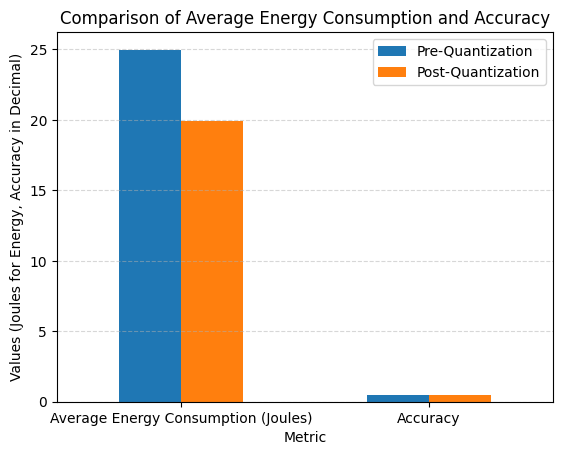

<Figure size 1200x600 with 0 Axes>

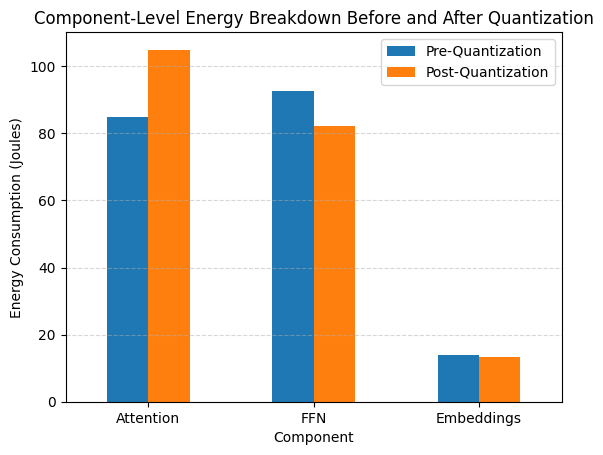

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Data for plotting
metrics = ['Average Energy Consumption (Joules)', 'Accuracy']
pre_quant = [24.9774, 0.5034]
post_quant = [19.9107, 0.5023]

components = ['Attention', 'FFN', 'Embeddings']
pre_quant_components = [84.8216, 92.6660, 13.9985]
post_quant_components = [104.9442, 82.1404, 13.4308]

# Create a DataFrame for easy plotting
df_energy = pd.DataFrame({
    'Metric': metrics,
    'Pre-Quantization': pre_quant,
    'Post-Quantization': post_quant
})

df_components = pd.DataFrame({
    'Component': components,
    'Pre-Quantization': pre_quant_components,
    'Post-Quantization': post_quant_components
})

# Plot average energy consumption and accuracy
plt.figure(figsize=(10, 6))
df_energy.set_index('Metric').plot(kind='bar', rot=0)
plt.title('Comparison of Average Energy Consumption and Accuracy')
plt.ylabel('Values (Joules for Energy, Accuracy in Decimal)')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

# Plot component-level energy breakdown
plt.figure(figsize=(12, 6))
df_components.set_index('Component').plot(kind='bar', rot=0)
plt.title('Component-Level Energy Breakdown Before and After Quantization')
plt.ylabel('Energy Consumption (Joules)')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


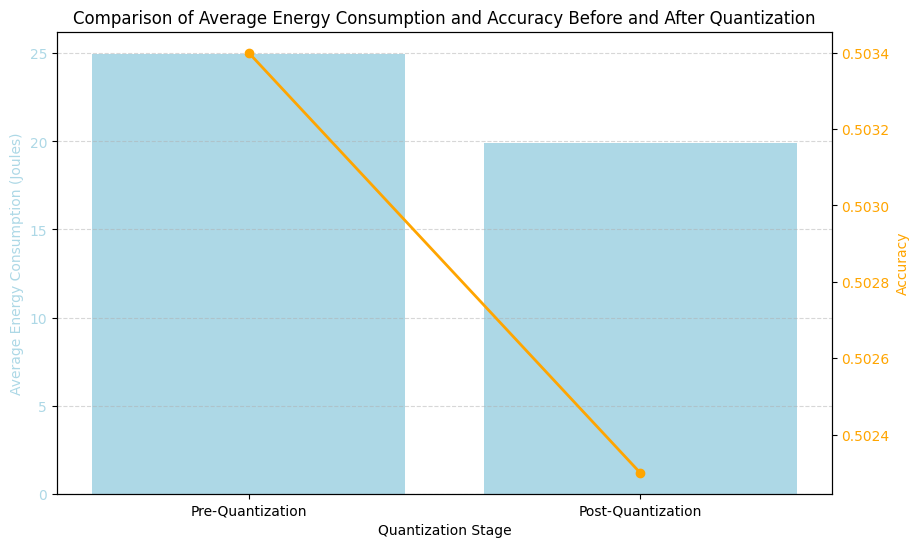

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Data for plotting
metrics = ['Average Energy Consumption (Joules)', 'Accuracy']
pre_quant_energy = 24.9774
post_quant_energy = 19.9107
pre_quant_accuracy = 0.5034
post_quant_accuracy = 0.5023

# Plot average energy consumption and accuracy with dual y-axes
fig, ax1 = plt.subplots(figsize=(10, 6))

# Primary y-axis for energy consumption
ax1.bar(['Pre-Quantization', 'Post-Quantization'], [pre_quant_energy, post_quant_energy], color='lightblue')
ax1.set_xlabel('Quantization Stage')
ax1.set_ylabel('Average Energy Consumption (Joules)', color='lightblue')
ax1.tick_params(axis='y', labelcolor='lightblue')
ax1.set_title('Comparison of Average Energy Consumption and Accuracy Before and After Quantization')
ax1.grid(axis='y', linestyle='--', alpha=0.5)

# Secondary y-axis for accuracy
ax2 = ax1.twinx()
ax2.plot(['Pre-Quantization', 'Post-Quantization'], [pre_quant_accuracy, post_quant_accuracy], color='orange', marker='o', linewidth=2)
ax2.set_ylabel('Accuracy', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

plt.show()


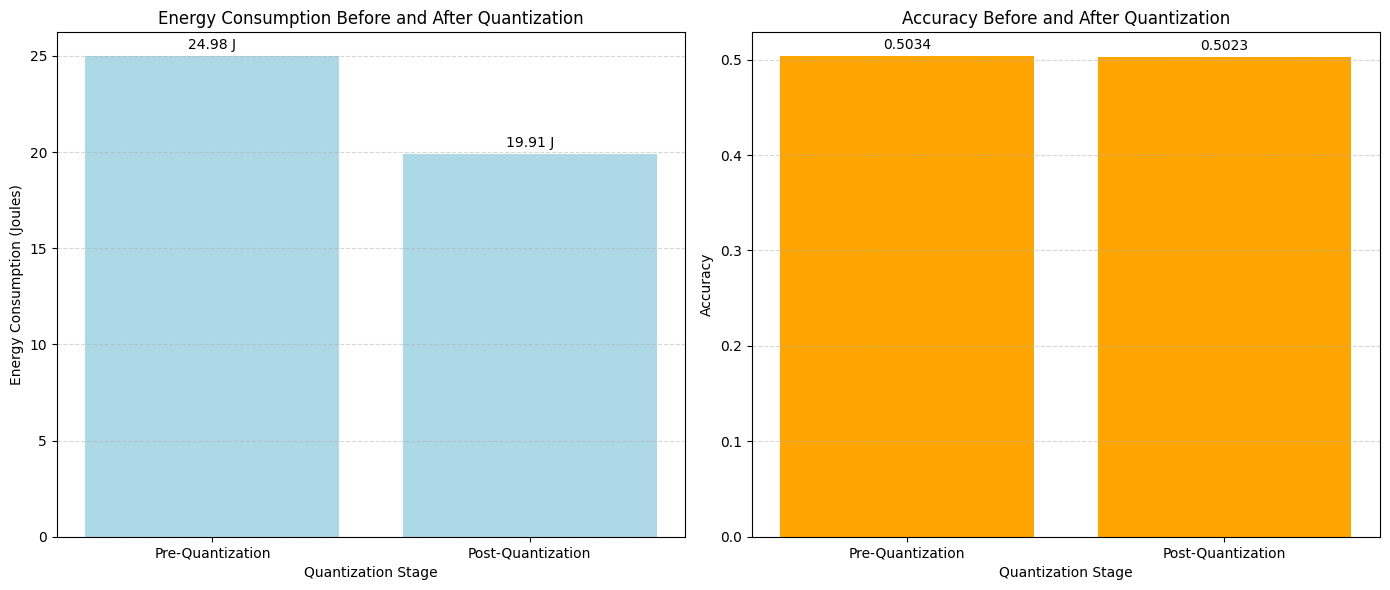

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data for plotting
stages = ['Pre-Quantization', 'Post-Quantization']
energy_values = [24.9774, 19.9107]
accuracy_values = [0.5034, 0.5023]

# Create two subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot energy consumption
axes[0].bar(stages, energy_values, color='lightblue')
axes[0].set_title('Energy Consumption Before and After Quantization')
axes[0].set_ylabel('Energy Consumption (Joules)')
axes[0].set_xlabel('Quantization Stage')
axes[0].grid(axis='y', linestyle='--', alpha=0.5)

# Annotate energy values
for i, value in enumerate(energy_values):
    axes[0].annotate(f'{value:.2f} J', (i, value), textcoords="offset points", xytext=(0, 5), ha='center')

# Plot accuracy
axes[1].bar(stages, accuracy_values, color='orange')
axes[1].set_title('Accuracy Before and After Quantization')
axes[1].set_ylabel('Accuracy')
axes[1].set_xlabel('Quantization Stage')
axes[1].grid(axis='y', linestyle='--', alpha=0.5)

# Annotate accuracy values
for i, value in enumerate(accuracy_values):
    axes[1].annotate(f'{value:.4f}', (i, value), textcoords="offset points", xytext=(0, 5), ha='center')

# Adjust layout
plt.tight_layout()
plt.show()



